In [1]:
!pwd

/c/projects/ask_my_resume/notebooks


In [2]:
import os
print(os.getcwd())
os.chdir("..")
print(os.getcwd())

In [52]:
from rag_pipeline.rag import rag

In [53]:
print(rag("What is the current company name"))

Securiti


In [66]:
from rag_pipeline.rag import vector_search, build_prompt

In [73]:
from openai import OpenAI
from rag_pipeline.config import API_KEY, LLM_MODEL

groq_client = OpenAI(api_key=API_KEY, 
                     base_url="https://api.groq.com/openai/v1")

def llm(prompt, llm_model="llama-3.3-70b-versatile"):
    response = groq_client.chat.completions.create(
        model=llm_model,  #LLM_MODEL,
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

def rag(query, sections=["Work Experience", "Projects", "Skills", "Education"], llm_model="llama-3.3-70b-versatile"):
    #print("model used: ", llm_model)
    search_results = vector_search(query, sections=sections)
    prompt = build_prompt(query, search_results)
    return llm(prompt, llm_model=llm_model)

In [75]:
print(rag("What is the current company name", llm_model="llama-3.1-8b-instant"))

Afiniti Software Solutions Ltd.


### Embeddings

We'll generate embeddings using the sentence transformers library

In [25]:
from sentence_transformers import SentenceTransformer
# Trained on real QA pairs from diverse domains & optimized for cosine similarity
# so ideal for RAG and Q&A-style tasks
model_name_qa = 'multi-qa-MiniLM-L6-cos-v1'  #'all-MiniLM-L6-v2'
model_qa = SentenceTransformer(model_name_qa)

# Smaller and slightly more general-pupose than multi-qa-*
model_name_all = 'all-MiniLM-L6-v2'
model_all = SentenceTransformer(model_name_all)

## Ground Truth Data

In [9]:
import json

with open("data/resume.json", "r", encoding="utf-8") as f:
    document_raw = json.load(f)

In [10]:
prompt_template = """
You are an interviewer preparing for a behavioral or technical interview.
Your goal is to write 5 clear and complete questions that would directly elicit the following resume entry as an answer.
Only ask questions that can be directly answered using the provided entry. 
If the entry only includes company, job title, location, and dates, avoid asking technical or project-based questions.
Avoid copying exact phrases from the resume — the questions should sound natural, but their answers should be well covered by the entry.

section: {section}
entry: {text}

Provide the output in a JSON array only without using code blocks:
["question1", "question2", ..., "question5"]
""".strip()

In [12]:
doc = document_raw[5]
prompt = prompt_template.format(
        section=doc["metadata"]["section"],
        text=doc["text"]
    )
print(prompt)

You are an interviewer preparing for a behavioral or technical interview.
Your goal is to write 5 clear and complete questions that would directly elicit the following resume entry as an answer.
Only ask questions that can be directly answered using the provided entry. 
If the entry only includes company, job title, location, and dates, avoid asking technical or project-based questions.
Avoid copying exact phrases from the resume — the questions should sound natural, but their answers should be well covered by the entry.

section: Work Experience
entry: Iteratively improved model accuracy through prompt-formatted instructions and data augmentation techniques, utilizing AI copilots like Claude Code to automate data transformations.

Provide the output in a JSON array only without using code blocks:
["question1", "question2", ..., "question5"]


In [13]:
def generate_questions(doc):
    prompt = prompt_template.format(
        section=doc["metadata"]["section"],
        text=doc["text"]
    )

    response = openai_client.chat.completions.create(
        model='gpt-4o-mini',
        messages=[{"role": "user", "content": prompt}]
    )

    json_response = response.choices[0].message.content
    return json_response

In [14]:
from tqdm.auto import tqdm

In [17]:
print(len(document_raw))
type(document_raw)

19


list

In [18]:
19*5

95

In [ ]:
print(document_raw[5]) # 0, 6, 

print(generate_questions(document_raw[7]))

In [ ]:
results = {}

In [ ]:
for doc in tqdm(document_raw): 
    doc_id = doc['id']
    if doc_id in results:
        continue

    questions = generate_questions(doc)
    #print(questions)
    results[doc_id] = questions

In [ ]:
len(results)

In [ ]:
doc_id_to_section = {doc['id']:  doc["metadata"]["section"] for doc in document_raw}

# Flatten the results into a list of rows
rows = []
for doc_id, question_list in results.items():
    section = doc_id_to_section.get(doc_id, "Unknown")

     # Fix improperly stored stringified lists
    if isinstance(question_list, str):
        try:
            question_list = json.loads(question_list)
        except json.JSONDecodeError:
            print(f"Failed to decode questions for doc_id {doc_id}")
            continue
            
    for question in question_list:
        #print(question)
        rows.append({
            "question": question,
            "section": section,
            "doc_id": doc_id
        })

# Convert to DataFrame
df = pd.DataFrame(rows)

In [ ]:
len(rows)

In [ ]:
df.to_csv('data/ground_truth_data.csv', index=False)

In [ ]:
!head data/ground_truth_data.csv

In [19]:
import pandas as pd
df_ground_truth = pd.read_csv('data/ground_truth_data.csv')
df_ground_truth.head()

,question,section,doc_id
0,What is your current job title and where do yo...,Work Experience,ae0142cf-58e4-408a-b2c3-950b9864f8e9
1,Can you tell me about the location of your cur...,Work Experience,ae0142cf-58e4-408a-b2c3-950b9864f8e9
2,When did you start your current position?,Work Experience,ae0142cf-58e4-408a-b2c3-950b9864f8e9
3,Are you currently working as a Data Scientist?,Work Experience,ae0142cf-58e4-408a-b2c3-950b9864f8e9
4,What company are you employed with at the moment?,Work Experience,ae0142cf-58e4-408a-b2c3-950b9864f8e9


In [20]:
ground_truth = df_ground_truth.to_dict(orient='records')
len(ground_truth)

95

In [81]:
#creating an index on document_raw to quickyl retrive the doc id answer from document_raw:
# builds a dictionary (lookup index) where  key is id value from each document, and value is the full document entry
doc_idx = {d["id"]: d for d in document_raw}

# # Now you can instantly access:
# doc_text = doc_idx['3e1e2fd4-45c5-47dd-b4e6-f68835f53f6d']["text"]
# doc_section = doc_idx['3e1e2fd4-45c5-47dd-b4e6-f68835f53f6d']["metadata"]["section"]
# doc_text

In [ ]:
ground_truth[4]['question']

In [ ]:
rag(ground_truth[4]['question'])

### llama-3.3-70b-versatile

In [ ]:
answers = {}

In [ ]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue
    #print(rec['question'])
    answer_llm = rag(rec['question'])
    doc_id = rec['doc_id']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'doc_id': doc_id,
        'question': rec['question'],
        'section': rec['section'],
    }

In [ ]:
len(answers)

In [ ]:
df_results_llama = pd.DataFrame(answers.values())#.sample(5).to_dict(orient='records')
#os.makedirs('data', exist_ok=True)
# df_results_llama.to_csv('data/results_llama-3.3-70b-versatile.csv', index=False)

In [22]:
df_results_llama = pd.read_csv('data/results_llama-3.3-70b-versatile.csv')

In [29]:
results_llama = df_results_llama.to_dict(orient='records')

In [32]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    # v_llm = model_qa.encode(answer_llm)
    # v_orig = model_qa.encode(answer_orig)
    
    v_llm = model_all.encode(answer_llm)
    v_orig = model_all.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [33]:
similarity = []

for record in tqdm(results_llama):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/95 [00:00<?, ?it/s]

In [31]:
df_results_llama['cosine_qa'] = similarity
df_results_llama['cosine_qa'].describe()
df_results_llama.groupby('section')['cosine_qa'].describe()

,count,mean,std,min,25%,50%,75%,max
section,,,,,,,,
Education,10.0,0.527080,0.228442,0.052174,0.425303,0.564721,0.702172,0.759555
Projects,10.0,0.655759,0.182994,0.381100,0.505373,0.655294,0.769978,0.923424
Skills,5.0,0.481072,0.115442,0.358570,0.359693,0.512676,0.582870,0.591552
Work Experience,70.0,0.594996,0.272041,-0.077712,0.532729,0.682576,0.785674,0.929522


In [34]:
df_results_llama['cosine_all'] = similarity
df_results_llama['cosine_all'].describe()
df_results_llama.groupby('section')['cosine_all'].describe()

,count,mean,std,min,25%,50%,75%,max
section,,,,,,,,
Education,10.0,0.510713,0.182568,0.090166,0.445921,0.543154,0.653294,0.685782
Projects,10.0,0.740273,0.143630,0.535940,0.633322,0.746957,0.850453,0.945555
Skills,5.0,0.491292,0.149535,0.284191,0.418129,0.485872,0.620672,0.647595
Work Experience,70.0,0.633545,0.267725,-0.061153,0.583262,0.727893,0.805798,0.926139


In [36]:
import seaborn as sns

In [38]:
import matplotlib.pyplot as plt

C:\Users\Nida Khan\AppData\Local\Temp\ipykernel_22856\1557422016.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_results_llama['cosine_qa'], label='cosine_qa')
C:\Users\Nida Khan\AppData\Local\Temp\ipykernel_22856\1557422016.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_results_l

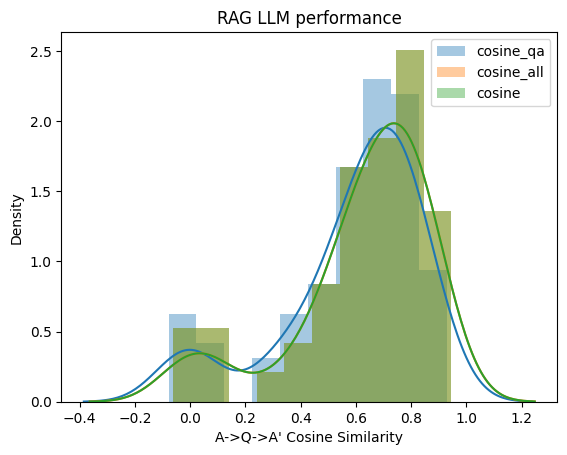

In [76]:
sns.distplot(df_results_llama['cosine_qa'], label='cosine_qa')
sns.distplot(df_results_llama['cosine_all'], label='cosine_all')
sns.distplot(df_results_llama['cosine'], label='cosine')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

In [82]:
answers = {}

In [83]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue
    #print(rec['question'])
    answer_llm = rag(rec['question'], llm_model="llama-3.1-8b-instant")
    doc_id = rec['doc_id']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'doc_id': doc_id,
        'question': rec['question'],
        'section': rec['section'],
    }

  0%|          | 0/95 [00:00<?, ?it/s]

In [92]:
df_results = pd.DataFrame(answers.values())#.sample(5).to_dict(orient='records')
#os.makedirs('data', exist_ok=True)
# df_results_llama.to_csv('data/results_llama-3.3-70b-versatile.csv', index=False)

In [ ]:
df_results = pd.read_csv('data/results_llama-3.3-70b-versatile.csv')

In [87]:
#df_results = df_results.to_dict(orient='records')

In [88]:
similarity = []

for record in tqdm(df_results):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/95 [00:00<?, ?it/s]

In [93]:
df_results['cosine_all'] = similarity
df_results['cosine_all'].describe()
df_results.groupby('section')['cosine_all'].describe()

,count,mean,std,min,25%,50%,75%,max
section,,,,,,,,
Education,10.0,0.551157,0.135180,0.209889,0.553061,0.581034,0.619167,0.677186
Projects,10.0,0.661562,0.228723,0.064837,0.647266,0.690888,0.764055,0.896328
Skills,5.0,0.473606,0.121589,0.315682,0.416995,0.483207,0.505718,0.646428
Work Experience,70.0,0.602707,0.209640,-0.045038,0.516511,0.639194,0.758682,0.930186


C:\Users\Nida Khan\AppData\Local\Temp\ipykernel_22856\1810249457.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_results_llama['cosine_all'], label='llama-versatile')
C:\Users\Nida Khan\AppData\Local\Temp\ipykernel_22856\1810249457.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_re

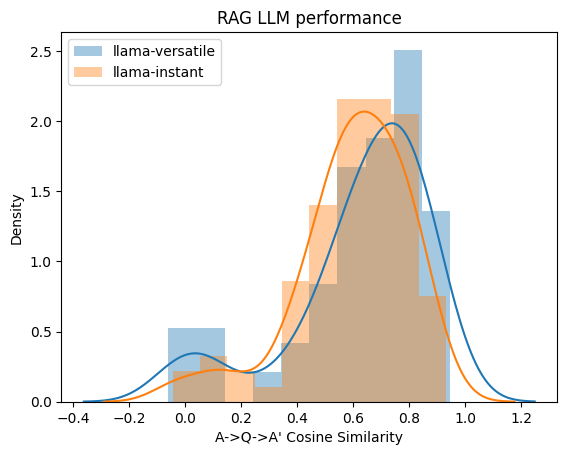

In [96]:
sns.distplot(df_results_llama['cosine_all'], label='llama-versatile')
sns.distplot(df_results['cosine_all'], label='llama-instant')
#sns.distplot(df_results_llama['cosine'], label='cosine')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()